In [1]:
import pandas as pd
import numpy as np  
import seaborn as sns 
import matplotlib.pyplot as plt
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import urllib        #for url stuff
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import os  # for os commands
from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import base64
from bokeh.embed import components
output_notebook()
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

<div class="bk-root">
        <a href="https://bokeh.pydata.org" target="_blank" class="bk-logo bk-logo-small bk-logo-notebook"></a>
        <span id="f1ec9950-5521-496f-918e-da442a21bffc">Loading BokehJS ...</span>
    </div>

<div class="bk-root">
        <a href="https://bokeh.pydata.org" target="_blank" class="bk-logo bk-logo-small bk-logo-notebook"></a>
        <span id="f1ec9950-5521-496f-918e-da442a21bffc">Loading BokehJS ...</span>
    </div>

In [2]:
#Read and merge dataset
s = time.time()
train_fr_1 = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv')
train_fr_2 = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv')
train_fr = pd.concat([train_fr_1, train_fr_2])
train_fr_new = train_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]

train_df = pd.read_csv('data/new-york-city-taxi-with-osrm/train.csv')
train = pd.merge(train_df, train_fr_new, on = 'id', how = 'left')
train_df = train.copy()
end = time.time()
print("Time taken: {}.".format((end-s)))
print(train_df.head(5))
print("list of train_fr_1:\n",list(train_fr_1))
print("list of train_fr_2:\n",list(train_fr_2))
print("list of train_fr:\n",list(train_fr))
print("list of train_fr_new:\n",list(train_fr_new))
print("list of train_df:\n",list(train_df))
print("list of train & train_df:\n",list(train))

Time taken: 24.05001401901245.
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  total_distance  \
0         40.765602     

# checking if Ids are unique, and the number of Nulls.

In [3]:
# checking if Ids are unique, and the number of Nulls.
start = time.time()
train_data = train_df.copy()
start = time.time()
print("Respectively, number of columns and rows and columns are {} and {} .".format(train_data.shape[1], train_data.shape[0]))
if train_data.id.nunique() == train_data.shape[0]: #nunique(): Return number of unique elements in the object.
    print("Train ids are unique")
print("Number of Nulls : {}.".format(train_data.isnull().sum().sum()))
end = time.time()
print("Time taken {}.".format(end-start))

Respectively, number of columns and rows and columns are 14 and 1458644 .


Train ids are unique


Number of Nulls : 3.
Time taken 1.1445887088775635.


#  Visualize the trip duration given using log-scale distplot in sns:

Time taken by above cell is 1.6149873733520508.


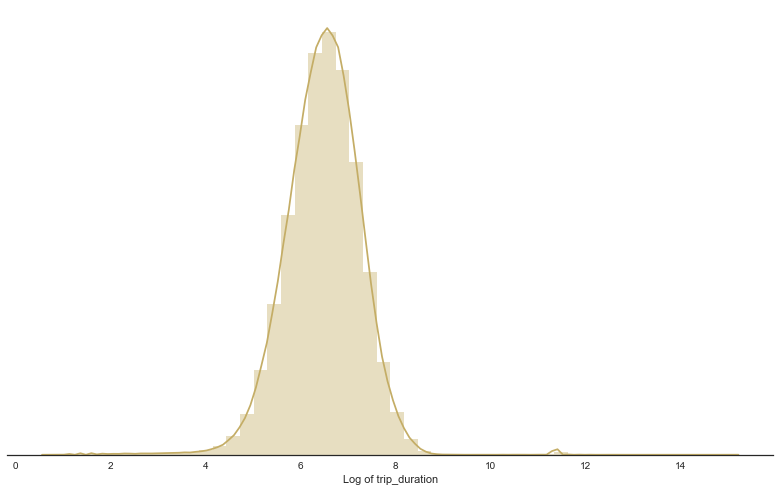

In [4]:
#1.First check what kind of trips durations are present in the dataset,
#2. When plotted it on a plain scale and not on a log scale, and some of the records have very long trip durations-100 hours.
# They are making all another trip invisible in the histogram on plain scale => go ahead with the log scale. 
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train_df['trip_duration'].values+1), axlabel = 'Log of trip_duration', label = 'Get the log(trip_duration)', bins = 50, color="y")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()


##  From the chart, the trip-durations are like Gaussian and few trips have very large duration, 
##  1. Most: most of the trips are e^4 = 1 minute to e^8 ~ 60 minutes: probably are taken inside Manhattan or in new york only
##  2. Outlier: like more than 350000 seconds which is 100 hours (it is weird and should be removed.)

#  Check the lat-long distributions are then used them to have a heat map kind of view of given lat-longs.

Time taken by above cell is 1.9481804370880127.


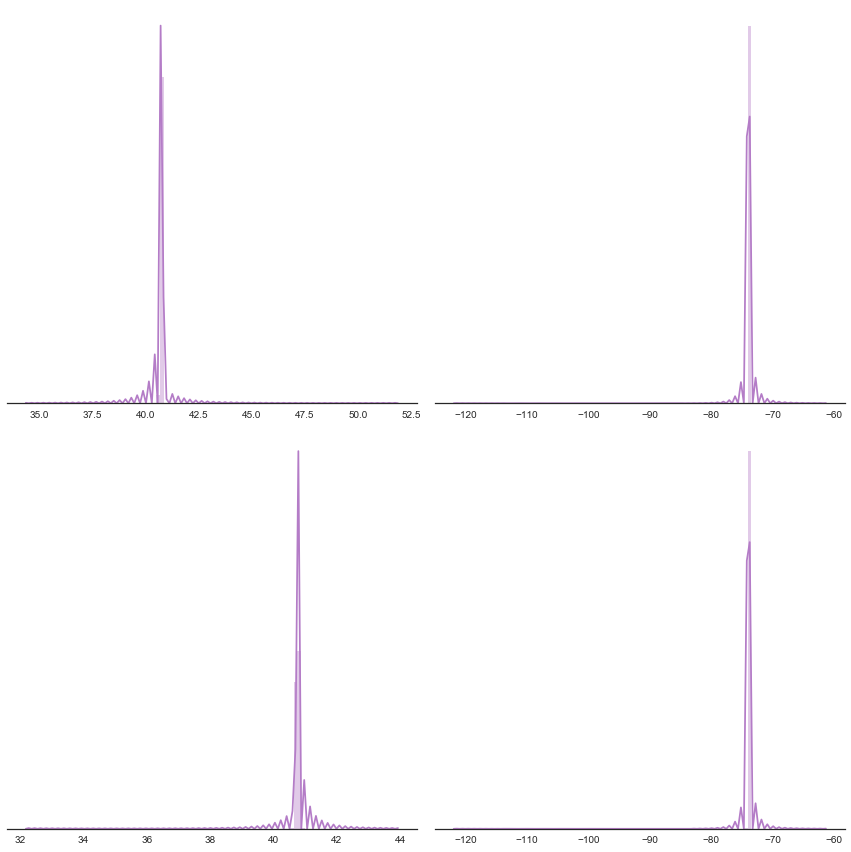

In [5]:
# Create a figure and a set of subplots
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train_df['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_df['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train_df['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_df['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

##  Findings:
##  1. Pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73. 
##  2. Trips which are very far from each other like lat 32 to lat 44, are taking very long time, and have affected this plot such that it is coming off as a spike. 

#  Remove those large duration trip by using a cap on lat-long and visualize trip duration given using log-scale distplot in sns:

In [6]:
# Remain the items with latitude & longitude between 40.6-40.9 and -74.05--73.7:
%matplotlib inline

df = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]

train_data_new = df.copy()
print(train_data_new.head(4))

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   

   dropoff_latitude store_and_fwd_flag  trip_duration  total_distance  \
0         40.765602                  N            455          2009.1   
1         40.731152                  N            663          2513.2   
2         40.710087                  N           2124 

Time taken: 2.009345531463623.
1452385 1458644


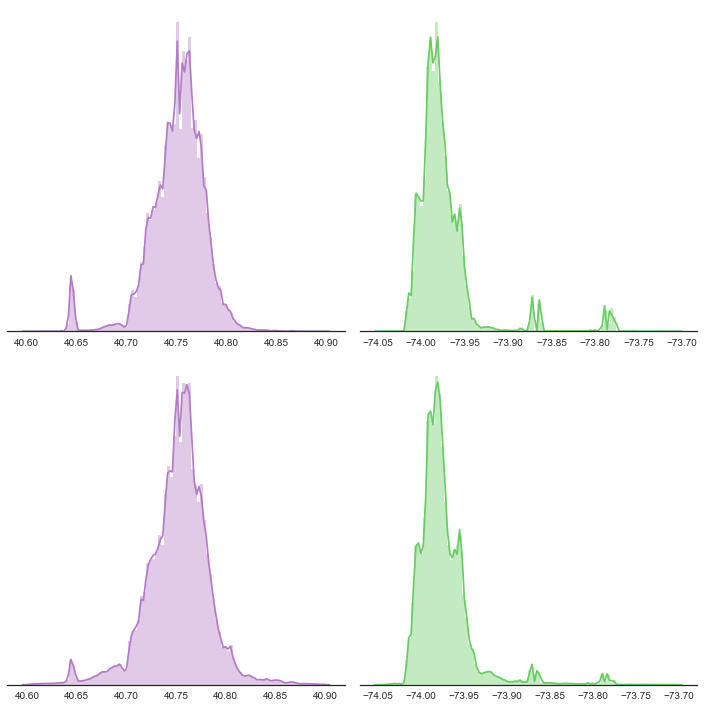

In [7]:
# Visualize the distribution of pickup & dropoff lat-long:
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True) # Remove the top and right spines from plot(s)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

end = time.time()
print("Time taken: {}.".format((end-start)))
print(df.shape[0], train_data.shape[0])
plt.show()

##  Findings:put the following caps on lat-long - Most duration centered around these ranges:
##  latitude should be between 40.6 to 40.9
##  Longitude should be between -74.05 to -73.70

#  Plot them on an empty image and check what kind of a city map--Check it in Chrome .html.

In [8]:
print(train_data.head(3))

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude store_and_fwd_flag  trip_duration  total_distance  \
0         40.765602                  N            455          2009.1   
1         40.731152                  N            663          2513.2   
2         40.710087                  N           2124         11060.8   

   total_travel_time  number_of_steps  
0              164.9              5.0  
1              332.0              6.0  
2    

In [9]:
start = time.time()
temp = train_data.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_date'] = train_data['pickup_datetime'].dt.date
train_data.head()

ts_v1 = pd.DataFrame(train_data.loc[train_data['vendor_id']==1].groupby('pick_date')['trip_duration'].mean())
ts_v1.reset_index(inplace = True)
ts_v2 = pd.DataFrame(train_data.loc[train_data.vendor_id==2].groupby('pick_date')['trip_duration'].mean())
ts_v2.reset_index(inplace = True)

from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from bokeh.plotting import figure, output_file, show
from bokeh.embed import components

#from bokeh.sampledata.stocks import AAPL, IBM, MSFT, GOOG
output_file("bokeh.html")

p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
p.title.text = 'Click on legend entries to hide the corresponding lines'

for data, name, color in zip([ts_v1, ts_v2], ["vendor 1", "vendor 2"], Spectral4):
    df = data
    p.line(df['pick_date'], df['trip_duration'], line_width=2, color=color, alpha=0.8, legend=name)

p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)

script, div = components(p)
end = time.time()
train_data = temp
print("Check the bokeh.html.")
print("Time Taken: {}.".format(end - start))

<div class="bk-root">
    <div class="bk-plotdiv" id="c57a2938-8f76-4422-b756-0e1b6587ee45"></div>
</div>

<div class="bk-root">
    <div class="bk-plotdiv" id="c57a2938-8f76-4422-b756-0e1b6587ee45"></div>
</div>

Check the bokeh.html.
Time Taken: 6.563435316085815.


#  Basic image processing

##  Consider each point of this image as a point represented by lat-long
## Then take a summary of lat-long and their count, assign a different color for different count range.

In [10]:
print('pickup_latitude:\n',train_data_new['pickup_latitude'].head(3))
print('dropoff_latitude:\n',train_data_new['dropoff_latitude'].head(3))
print('pickup_longitude:\n',train_data_new['pickup_longitude'].head(3))
print('dropoff_longitude:\n',train_data_new['dropoff_longitude'].head(3))
print('train_data_new:\n',train_data_new.head(1))


pickup_latitude:
 0    40.767937
1    40.738564
2    40.763939
Name: pickup_latitude, dtype: float64
dropoff_latitude:
 0    40.765602
1    40.731152
2    40.710087
Name: dropoff_latitude, dtype: float64
pickup_longitude:
 0   -73.982155
1   -73.980415
2   -73.979027
Name: pickup_longitude, dtype: float64
dropoff_longitude:
 0   -73.964630
1   -73.999481
2   -74.005333
Name: dropoff_longitude, dtype: float64
train_data_new:
           id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937          -73.96463   

   dropoff_latitude store_and_fwd_flag  trip_duration  total_distance  \
0         40.765602                  N            455          2009.1   

   total_travel_time  number_of_steps  
0              164.9              5.0  


In [11]:
# Create 3 arrays: with 3500 rows & 3 columns each.
start = time.time()
rgb = np.zeros((3000, 3500, 3), dtype=np.uint8) # 3000 arrays: with 3500 rows & 3 columns each.
rgb[..., 0] = 0 # Assign 0 to every items in column 0;
rgb[..., 1] = 0 # Assign 0 to every items in column 1;
rgb[..., 2] = 0 # Assign 0 to every items in column 2;

train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))
# map(): typecasting every element of the list to an integer value. 
# latitude should be between 40.6 to 40.9; Longitude should be between -74.05 to -73.70
summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

In [13]:
#Print new train data after transformation:
('pickup_latitude:\n',train_data_new['pick_lat_new'].head(3))
print('dropoff_latitude:\n',train_data_new['drop_lat_new'].head(3))
print('pickup_longitude:\n',train_data_new['pick_lon_new'].head(3))
print('dropoff_longitude:\n',train_data_new['drop_lon_new'].head(3))
# print('summary_plot:\n')
# summary_plot.head(100)

dropoff_latitude:
 0    1656
1    1311
2    1100
Name: drop_lat_new, dtype: int64
pickup_longitude:
 0    678
1    695
2    709
Name: pick_lon_new, dtype: int64
dropoff_longitude:
 0    853
1    505
2    446
Name: drop_lon_new, dtype: int64


Time taken by above cell is 44.897260665893555.


unit: [1]


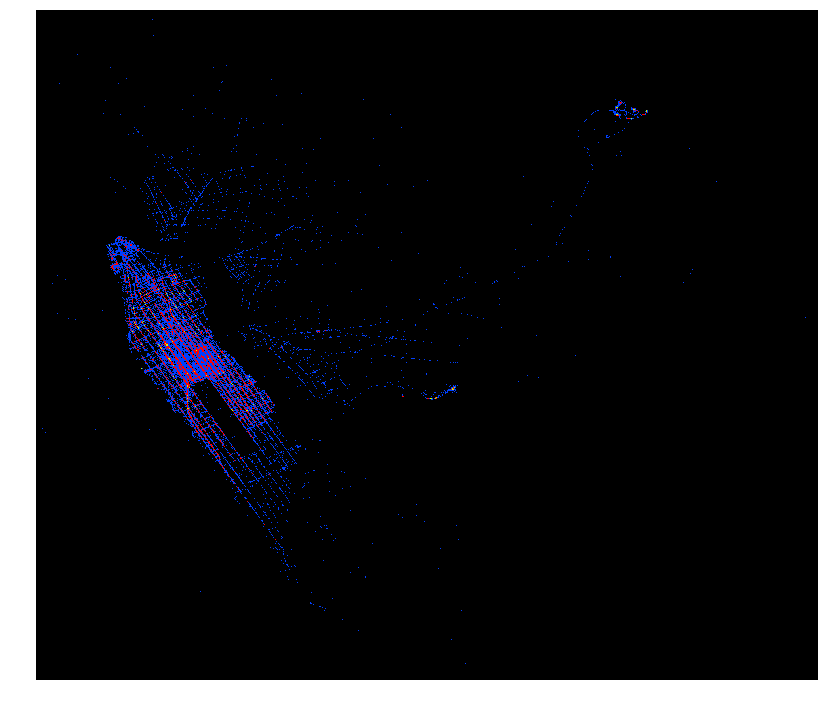

In [15]:
#Plot geograph:
summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()

for i in lat_list: #lat_list: list of unique 'pick_lat_new'
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    # Get the longitude mapping with unique latitude.
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    # Get the id mapping with unique latitude.
    
    for j in lon_list: 
        a = unit[lon_list.index(j)] # lon_list.index(j): return the index of lon_list(j)
        if (a//50) >0: # //: Floor Division: the result is the quotient in which the digits after decimal points are not taken into account.
            rgb[i,j, 0] = 191 #Label the count>50 with Green
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        elif (a//10)>0: #Label the count>10 with Red
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        else: #Label the count>10 with blue
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 64
            rgb[i,j, 2] = 255

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

print('unit:',unit)


In [16]:
print(lon_list)
print(lon_list.index)

[2501]
<built-in method index of list object at 0x000001E95166EE88>


# Formally begin feature extraction

##  Define some functions to caculate distance：

In [18]:

def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

import math
def bearing_array(lat1, lng1, lat2, lng2):
    """ function was taken from beluga's notebook as this function works on array
    """
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

Time taken by above cell is 260.7570836544037.


##  Feature extraction 

In [19]:
start = time.time()
train_data = temp.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_month'] = train_data['pickup_datetime'].dt.month
train_data.loc[:, 'hour'] = train_data['pickup_datetime'].dt.hour
train_data.loc[:, 'week_of_year'] = train_data['pickup_datetime'].dt.weekofyear
train_data.loc[:, 'day_of_year'] = train_data['pickup_datetime'].dt.dayofyear
train_data.loc[:, 'day_of_week'] = train_data['pickup_datetime'].dt.dayofweek
train_data.loc[:,'hvsine_pick_drop'] = haversine_(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'bearing'] = bearing_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

end = time.time()
print("Time taken by above cell is {}.".format(end-start))

Time taken by above cell is 4.161067485809326.


# Features' Exploration (Check if any explainable pattern)

##  Visualize the average time taken by two different vendors vs weekday

C:\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



0.42688655853271484


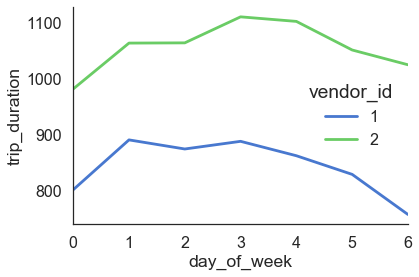

In [20]:
start = time.time()
summary_wdays_avg_duration = pd.DataFrame(train_data.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)
end = time.time()
print(end - start)

##  Findings:
##  Vendor 1 is taking more time than vendor 2 on all the days of the week.